In [1]:
import os
import copy
from __future__ import print_function

#Manejo de matrices y tablas
import numpy as np
import pandas as pd

#Estadistica y funciones matemáticas
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 
import pyreadr
import scipy.io as sio
from itertools import combinations
from sklearn.model_selection import train_test_split

#Probabilistic programs
#!pip install pymc3
#!pip install pymc==4.0.0b1
import pymc3 as pm
#import pymc as pm
#import aesara.tensor as at
import theano.tensor as tt 
from theano.compile.ops import as_op
print('Running on PyMC v{}'.format(pm.__version__))

#!pip install HDDM Bayesian drift diffussion
import hddm #WARNING: from hddm 0.9 onward works (pip install cython pip install pymc pip install git+https://github.com/hddm-devs/kabuki pip install git+https://github.com/hddm-devs/hddm )
print ("hddm version: ", hddm.__version__)

#Graficas
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az
import colorsys

# Image processing stuff
#!pip install opencv-python
import cv2

#Funciones propias (tienen que estar en el mismo directorio)
import my_fun as mf

Running on PyMC3 v3.9.3
hddm version:  0.8.0


/home/santiago/anaconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


# Decision criterion

Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

## Drift diffusion

Enigma & Turing [Video recomendado](https://www.youtube.com/watch?v=G2_Q9FoD-oQ) <br><br>


<center><img src="img/9_CB/DDM1.png" width = "801" height = '800'></center>

El código era probabilístico (pseudo-uniforme, los alemanes nunca usaban la misma letra en el código y el mensaje) SI no se conocia la posición de los rotores

<center><img src="img/9_CB/DDM2.png" width = "601" height = '600'></center>

Las maquinas eran similares en como producian códigos aleatorios (sistema mecánico con rotores en posiciones iniciales; similar a random seeds hoy en día) <br> <br>

<center><img src="img/9_CB/DDM5.png" width = "701" height = '700'></center>

Si dos códigos interceptados compartían letra en la misma posición era probable que fuera la misma maquina/posición de rotores. <br><br>

<center><img src="img/9_CB/DDM3.png" width = "501" height = '500'></center>

Podemos acumular información ruidosa hasta un umbral para decidir si en efecto son la misma maquina (umbral superior) o diferente (umbral inferior) y empezar a decodificar <br><br>

<center><img src="img/9_CB/DDM4.png" width = "501" height = '500'></center>

¿Qué tiene que ver esto con cognición bayesiana y decisiones?

La actividad cerebral es ruidosa. Antes de decidir, LIP acumula actividad de MT hasta un umbral para confirmar. <br><br>

<center><img src="img/9_CB/DDM6.svg" width = "701" height = '700'></center>
Roitman & Shadlen (2002)

Los parametros usuales son drift rate, bound levels, starting point, and non-decision times. <br>
En muchas versiones del DDM (no todas), se acumula el likelihood ratio (asume prior uniforme): $\frac{p(evidencia|decisión \ 1)}{p(evidencia|decisión \ 2)}$ <br>
En otras versiones, se acumula una variable de decision que se puede inferir dadas las acciones y tiempos de respuesta <br><br>


<center><img src="img/9_CB/DDM7.svg" width = "801" height = '800'></center>
Shadlen & Kiani (2002)

¿Cuál es el rojo más brillante? <br><br><br>
<center><img src="img/9_CB/DDM8.svg" width = "501" height = '500'></center>
<br><br><br>

¿Cuál es el rojo más brillante? <br><br><br>
<center><img src="img/9_CB/DDM9.svg" width = "501" height = '500'></center>
<br><br><br>

¿Cuál es el rojo más brillante? <br><br><br>
<center><img src="img/9_CB/DDM10.svg" width = "501" height = '500'></center>
<br><br><br>

¿En cuál turno fueron más lentos? En ese turno la evidencia se acumuló más lento (los otros parametros constantes) 

El framework de acumulación de evidencia se ha aplicado en (reviews en Ratcliff, et al, 2016; Shadlen & Kiani, 2013):

* Numerosidad
* Memoria
* Percepción de movimiento
* Lenguaje
* Categorización
* Marketing
* Altruismo
* Descuento intertemporal
* Otros

Hay varios algoritmos para estimar los parámetros del modelo (Tabla de Shinn, et al, 2020). Acá nos centramos en HDDM que es bayesiano (Wiecki, et al, 2013). <br><br>

<center><img src="img/9_CB/DDM11.svg" width = "601" height = '600'></center>

v: drift rate <br>
a: decision threshold <br>
z: starting point of accumulation <br>
ndt: non-decision times (e.g. encoding) <br>
$s_v, \ s_z, \ s_{ndt}$: inter-trial variability of parameters <br>
x: response time and choice <br>


<center><img src="img/9_CB/model_HDDM.svg" width = "601" height = '600'></center>

Vamos a usar el paquete HDDM (Wiecki, Sofer, and Frank, 2013) y el demo en http://ski.clps.brown.edu/hddm_docs/tutorial_python.html

El paquete está basado en PyMC. Sin embargo, requiere definiciones de densidades especiales para $x_{ji}$ por lo que mejor usamos el paquete.

Usaremos el experimento de Cavanagh, et al, (2011). Subthalamic nucleus stimulation reverses mediofrontal influence over decision threshold.

<center><img src="img/9_CB/Cav1.png" width = "601" height = '600'></center>

4 items. A: gana 100%; B: 0%; C: 75%; D: 25%. Probabilidades de ganar se aprenden via ensayo y error <br>
4 tipos de turno:
* High conflict WW win-win (A vs C); 
* High conflict LL lose-lose (B vs D); 
* Low-conflict WL (A vs D; C vs B). 

Hipótesis: High conflict trials aumentan el threshold.

In [ ]:
data = hddm.load_csv('data/9_CB/HDDM_data.csv')
data

Veamos los datos de los sujetos

In [ ]:
data = hddm.utils.flip_errors(data) #pone los tiempos de respuesta de errores en negativo.

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)



Ahora ajustar el modelo más simple donde los parametros no varían por condición

In [ ]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
#m = hddm.HDDM(data, include=('z', 'sv', 'st', 'sz')) #If you want to include inter-trial variability. SLOW
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(2000, burn=20)

Ahora veamos el parametro grupal umbral ($\mu_a$) y su variabilidad ($\sigma_a$), y su valor para un sujeto ($a_1$)

In [ ]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0'])]


In [ ]:
#Ahora el plot de los traces, autocorrelaciones (si van a cero indica buen sampling), e histogramas de algunos parámetros
m.plot_posteriors(['a', 't', 'v', 'a_std']) #group level parameters

Para correr varias cadenas hay que correr varias veces el comando. Con varias cadenas se puede calcular rhat (<1.1 convergio).

In [ ]:
models = []
nchains = 4
for i in range(nchains): 
    print("Cadena: ", i)
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(5000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models) #rhat<1.1 convergio

In [ ]:
#Plot posterior predictive (red data, blue model) (HDDM plot_posterior_predictive function was not working)
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        #if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
        #    continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]
        
def _plot_posterior_pdf_node(bottom_node, axis, value_range=None, samples=10, bins=100):
    """Calculate posterior predictive for a certain bottom node.
    :Arguments:
        bottom_node : pymc.stochastic
            Bottom node to compute posterior over. Bottom refers to individual level parameters.
        axis : matplotlib.axis
            Axis to plot into.
        value_range : numpy.ndarray
            Range over which to evaluate the likelihood.
    :Optional:
        samples : int (default=10)
            Number of posterior samples to use.
        bins : int (default=100)
            Number of bins to compute histogram over.
    """

    if value_range is None:
        # Infer from data by finding the min and max from the nodes
        #raise NotImplementedError("value_range keyword argument must be supplied.")
        value_range = np.linspace(-5, 5, 100) #in seconds

    like = np.empty((samples, len(value_range)), dtype=np.float32)
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node) #this obtains random parameters (a, v, ndt)
        # IMPORTANT ONE: Generate likelihood 
        like[sample,:] = bottom_node.pdf(value_range) #Basically, this is Navarro & Fuss (2009) likelihood

    y = like.mean(axis=0) #The mean of the posterior predictive
    try:
        y_std = like.std(axis=0)
    except FloatingPointError:
        print("WARNING! %s threw FloatingPointError over std computation. Setting to 0 and continuing." % bottom_node.__name__)
        y_std = np.zeros_like(y)

    # Plot pp
    axis.plot(value_range, y, label='post pred', color='b')
    axis.fill_between(value_range, y-y_std, y+y_std, color='b', alpha=.8)

    # Plot data
    if len(bottom_node.value) != 0:
        axis.hist(bottom_node.value.values, density=True, color='r',
                  range=(value_range[0], value_range[-1]), label='data',
                  bins=bins, histtype='step', lw=2.)

    axis.set_ylim(bottom=0) # Likelihood and histogram can only be positive


observeds = m.get_observeds()
max_items = max([len(i[1]) for i in observeds.groupby('tag').groups.items()])
columns = min(3, max_items)
num_subjs = observeds.shape[0]
for tag, nodes in observeds.groupby('tag'): #nodes are parameters e.g. bottom-node is a non-group level parameter
    fig = plt.figure(figsize=(10,30))
    #fig.suptitle(tag, fontsize=12)
    fig.subplots_adjust(top=0.9, hspace=.4, wspace=.3)

    nrows = num_subjs or len(nodes)/columns

    if len(nodes) - int(nrows * columns) > 0:
        nrows += 1

    # Plot individual subjects (if present)
    i = 0
    for subj_i, (node_name, bottom_node) in enumerate(nodes.iterrows()):
        i += 1
        
        ax = fig.add_subplot(int(np.ceil(nrows)), int(columns), int(subj_i+1))
        if 'subj_idx' in bottom_node:
            ax.set_title('Subj. ' + str(bottom_node['subj_idx']))

        _plot_posterior_pdf_node(bottom_node['node'], ax)

        if i >= np.ceil(nrows) * columns:
            warnings.warn('Too many nodes. Consider increasing number of columns.')
            break

        if num_subjs is not None and i >= num_subjs:
            break
    plt.tight_layout()

Con HDDM podemos calcular parametros por condicion (WW, LL, WL) usando la opción depends_on.

In [ ]:
m_stim = hddm.HDDM(data, depends_on={'v': 'stim', 'a': 'stim'}) # en depends_on, el value del diccionario es la columna en la data con la condición experimental
m_stim.find_starting_values()
m_stim.sample(4500, burn=1000)

#the sampled parameters are in .nodes_db.node. It is a pandas dataframe
v_WW, v_LL, v_WL = m_stim.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
a_WW, a_LL, a_WL = m_stim.nodes_db.node[['a(WW)', 'a(LL)', 'a(WL)']]
ndt = m_stim.nodes_db.node['t']

In [ ]:
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL]);
plt.xlabel('drift-rate');
plt.ylabel('Posterior probability');
plt.title('Posterior of drift-rate group-level means');

plt.figure();
hddm.analyze.plot_posterior_nodes([a_WW, a_LL, a_WL]);
plt.xlabel('bounds');
plt.ylabel('Posterior probability');
plt.title('Posterior of bounds group-level means');


plt.figure();
hddm.analyze.plot_posterior_nodes([ndt]);
plt.xlabel('non-decision times');
plt.ylabel('Posterior probability');
plt.title('Posterior of ndt group-level means');


In [ ]:
#Model comparison via DIC (lower is better)
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim.dic)

El paquete HDDM también puede calcular los parámetros con información externa via regresiones (e.g. que el drift dependa de la edad o actividad cerebral). Detalles en https://github.com/hddm-devs/hddm

El paquete HDDM no simula, usa formulas, sin embargo veamos aproximádamente una simulación para obtener la variable de decisión (la traza). Esto puede ser útil, por ejemplo, para calcular confianza en la decisión.
<br><br>
<center><img src="img/9_CB/Wiecki1.svg" width = "601" height = '600'></center>
Imagen: Wiecki, et al, 2013

In [ ]:
#Simulated DV (decision variable)
a = 20*a_WL.trace().mean() # bound
v = v_WL.trace().mean() # drift
t = ndt.trace().mean() # non-decision time
n_ttrrials = 200
sampling_rate = 1e-2 #arbitrary units 

#simulated_data, params = hddm.generate.gen_rand_data(params={'a': a, 'v': v, 't': t}, size=n_ttrrials) #No se estimo st, sv, sz
#print([simulated_data['rt'].mean() - t, simulated_data['response'].mean(), v,a,t])

z = np.random.uniform(-a/4,a/4)#Starting point
DVdt = np.append(np.array([z]), np.random.normal(v*sampling_rate, 1, 3000))
print(a, v, t, z, DV)
DV = np.cumsum(DVdt)
idx_below = np.argmax(DV<-a) #bottom threshold
idx_above = np.argmax(DV>a) #upper threshold
if min(idx_below, idx_above) == 0:
    idx_choice_time = max(idx_below, idx_above)
else:
    idx_choice_time = min(idx_below, idx_above)
choicee = 'correct'
if idx_choice_time==0: #never passed a threshold
    choicee = 'No threshold hit'
    idx_choice_time = len(DV)-1
elif idx_choice_time == idx_below: 
    choicee = 'wrong'
    
    
DV = DV[0:idx_choice_time]
#DV = DV[(DV<(a*sampling_rate)) & (DV>(-a*sampling_rate))]
plt.plot(DV);
print(v*sampling_rate, DV.shape[0], idx_choice_time, choicee)
#DV


Definamos confianza como p(choice=correct|DV). Implementemos esta idea en un ejercicio.

# Ejercicio 

* Simule el DV de un turno correcto e infiera la probabilidad de que DV es mayor a cero. Es decir, asuma que su data es el vector DV y quiere calcular si el posterior del promedio de DV es mayor a cero. Use un likelihood normal y un prior uniforme para el promedio y desviación estándar de DV (recuerde que la desviación estándar debe ser mayor a cero i.e. el prior va de [0, K]). 
    * Bono: hacerlo de dos formas, a) con pymc3 y b) con la formula para la densidad de una posterior con likelihood normal y priors uniformes.  

* Haga lo anterior (i.e. simule el DV) para 5 turnos WW, 5 turnos LL, y 5 turnos WL. ¿Cuál condición genera mayor confianza?

* ¿Qué pasa si baja el umbral? Hagalo solo con turnos WL.

## Signal detection theory


Le pedimos a un par de personas que detecte varias veces si hay un tono/señal/voz del más alla en un ambiente lleno de ruido. <br><br>
En la figura, Laurie dice "sí" más veces. ¿Es Laurie más sensible al tono/señal/voz del más alla que Chris?

<center><img src="img/9_CB/Goldstein1.png" width = "501" height = '500'></center>
Fuente: Goldestein, 1996, Sensation & Perception.

Laurie dice sí más y puede que genere más hits pero también más false alarms.<br><br>

|              | Signal + Noise trial |    Noise Trial    |
|--------------|:--------------------:|:-----------------:|
| Yes response |          Hit         |    False alarm    |
| No response  |         Miss         | Correct rejection |

eje x: fuerza de actividad interna (supuesto: ruido produce actividad más débil)<br>
$d$: distancia entre ruido y señal <br>
$d/2$: criterio de decisión optimo si turnos de ruido y señal ocurren con igual probabilidad <br>
$k$: criterio de decisión usado por la persona (e.g. si fuerza actividad>$k$, decir sí) <br>
$c$: sesgo i.e. criterio usado ($k$) menos criterio óptimo ($d/2$)<br>
$\theta^h$: probabilidad de hit <br>
$\theta^f$: probabilidad de false alarm <br>

<br><br>

<center><img src="img/9_CB/Lee_Wagenmakers1.svg" width = "501" height = '500'></center>
Fuente: Lee & Wagenmakers (2013)

# Ejercicio

* En la anterior figura, sombree el área que correspondería a "Miss" y cuál a "Correct Rejection".

Volviendo a Laurie y Chris, hay por lo menos dos hipótesis para estos datos:
* Laurie y Chris difieren en d (sensibilidad)
* Laurie y Chris difieren en k (criterio)
<br><br>
<center><img src="img/9_CB/Goldstein1.png" width = "501" height = '500'></center>
Fuente: Goldestein, 1996, Sensation & Perception.

No solo aplica para fenómenos perceptuales. Cualquier toma de decisión dependerá de la discriminibilidad y umbrales que se pongan.

<center><img src="img/9_CB/Krajbich1.svg" width = "451" height = '450'></center>
Fuente: Krajbich, et al, 2015

Krajbich, et al, 2015, de hecho encuentran que una vez controlando por discriminabilidad, la idea de thinking fast and slow (barras) desaparece (scatter plots).

| Dictator Game | Intertemporal Discounting |
|:-------------:|:-------------------------:|
|      <center><img src="img/9_CB/Krajbich2.svg" width = "451" height = '450'></center>      |        <center><img src="img/9_CB/Krajbich3.svg" width = "451" height = '450'></center>       |


En un marco que integre valor esperado y signal detection theory, los criterios óptimos podrían considerar valor esperado (Lynn, Wormwood, Barret, & Quigley, 2015). Acá, la decisión de cicla o carro depende tanto del valor esperado del método de transporte y la probabilidad de lluvia.
<br><br>

<center><img src="img/9_CB/Lynn1.jpg" width = "551" height = '550'></center>

Veamos ahora cómo implementar un modelo simple de signal detection theory (SDT) en PyMC 

$c_i:$ sesgo <br>
$d_i:$ distancia entre las distribuciones señal y ruido <br>
$\theta_i^f:$ Tasa de false alarm <br>
$\theta_i^h:$ Tasa de hit rate <br>
$h_i, \ f_i:$ Hits and false alarms observados, respectivamente <br>
$s_i, \ n_i:$ Número de signal y noise trials, respectivamente <br><br>


<center><img src="img/9_CB/model_SDT.svg" width = "551" height = '550'></center>

In [2]:
## Modelos basados en https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3
#  Load data
dataset = 1
if dataset == 1:  # Demo
    k = 3  # number of cases
    data = np.array([70, 50, 30, 50, 7, 5, 3, 5, 10, 0, 0, 10]).reshape(k, -1)
else:  # Lehrner et al. (1995) data
    k = 3  # number of cases
    data = np.array([148, 29, 32, 151, 150, 40, 30, 140, 150, 51, 40, 139]).reshape(
        k, -1
    )

# Number of ...
h = data[:, 0] #hits (each row is a subject)
f = data[:, 1] #false alarm
MI = data[:, 2] #miss
CR = data[:, 3] #correct rejection
s = h + MI #signal trials
n = f + CR #noise trials

In [3]:
def Phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    # Also it is the probit transform
    return 0.5 + 0.5 * pm.math.erf(x / pm.math.sqrt(2))

In [4]:
with pm.Model() as model1:
    #Priors
    di = pm.Normal("Discriminability", mu=0, tau=0.5, shape=k) #d
    ci = pm.Normal("Bias", mu=0, tau=2, shape=k) #c

    #Likelihood
    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))
    
    hi = pm.Binomial("hi", p=thetah, n=s, observed=h)
    fi = pm.Binomial("fi", p=thetaf, n=n, observed=f)
    
    #Sampling
    trace1 = pm.sample()
    data = az.from_pymc3(trace=trace1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bias, Discriminability]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


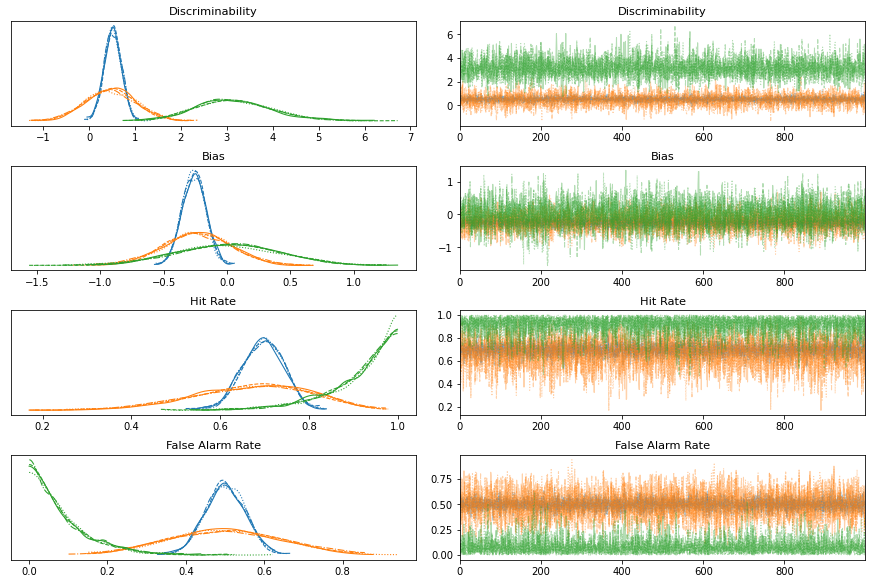

In [5]:
az.plot_trace(
    data, var_names=["Discriminability", "Bias", "Hit Rate", "False Alarm Rate"], compact=True
);

# Ejercicios

* ¿Qué significa qué los priors de discriminabilidad y sesgo estén centrados en cero? ¿Piensa que los priors de discriminabilidad y bias son los apropiados? Trate otros parámetros para la normal u otras formas funcionales y comente si observa (o no) cambios. 

* Analicé la siguiente tabla con signal detection theory (SDT). Use el modelo anterior de PyMC. En la tabla se muestra datos de un experimento con tres poblaciones y su capacidad de reconocer olores. Control: no COVID (n=18), Grupo 1: COVID severo (n=18), Grupo 2: COVID leve (n=19). El experimento era en tres fases. Primera: memorizar 10 olores. Segunda: esperar 15 minutos. Tercera: de 20 olores reconocer si son nuevos o viejos (10 eran nuevos, 10 viejos). La tabla tiene la suma agregada por grupo.
    * ¿Cuál es la discriminabilidad y sesgo de cada grupo?
    * ¿Qué conclusiones saca?
    * ¿Se puede decir algo de diferencias individuales en un mismo grupo?

|          |  Control |  Control | Group I  | Group I  | Group II | Group II |
|----------|:--------:|:--------:|----------|----------|----------|----------|
|          | Old odor | New odor | Old odor | New odor | Old odor | New odor |
| Old resp | 148      | 29       | 150      | 40       | 150      | 51       |
| New resp | 32       | 151      | 30       | 140      | 40       | 139      |

Ahora veamos una versión jerárquica de SDT

En los modelos jerárquicos asumimos que los parámetros, en este caso discriminabilidad y sesgos, varían entre sujetos, y esa variación viene de una distribución poblacional, en este caso representada por los prior $\mu_c, \ \mu_d, \ \lambda_c, \ \lambda_d$ <br><br>

<center><img src="img/9_CB/model_hSDT.svg" width = "551" height = '550'></center>

La data viene de un experimento de Heit & Rotello (2005) que trata de evaluar la conjetura que la diferencia entre razonamiento inductivo (particular a general; Juan, Sofia, Heriberto, Karla, son mortales; todos los hombres son mortales) y deductivo (general a particular; todos los hombres son mortales; Pepe es mortal) se puede enmarcar en signal detection theory.

Especificamente, la hipótesis es que el criterio de decision deductivo es mayor al inductivo (Rips, 2001).

Características del experimento:
* 80 participantes.  
* 8 argumentos
* Diseño between-subject 
* Los del grupo inductivo (n=40) respondían preguntas tipo "¿qué tan plausible?"
* Los del grupo deductivo (n=40) respondían preguntas tipo "¿es necesariamente verdad?"
* Se contaron los hits, false alarms, miss, y correct rejections.

Las preguntas siempre empezaban con: Asumiendo que las oraciones arriba de la línea son ciertas ... <br>
En la condición inductiva las preguntas eran del tipo: ¿qué tan plausible? ¿qué tan convincente? <br>
En la condición deductiva las preguntas eran del tipo: ¿Necesariamente implica? ¿Puede estar segura? <br>
<center><img src="img/9_CB/rips1.svg" width = "501" height = '500'></center>

<center><img src="img/9_CB/rips2.svg" width = "501" height = '500'></center>
Heit & Rotello (2005) 

In [8]:
std_d = pd.read_csv("data/9_CB/heit_rotello_std_d.csv") # deduction data
std_i = pd.read_csv("data/9_CB/heit_rotello_std_i.csv") # induction data

#Induction
h1  = np.array(std_i['V1']) #hits
f1  = np.array(std_i['V2']) #false alarm
MI1 = np.array(std_i['V3']) #miss
CR1 = np.array(std_i['V4']) #correct rejection
s1 = h1 + MI1 #signal trials
n1 = f1 + CR1 #noise trials

#Deduction
h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k = len(h1)

In [19]:
#Inductive model
with pm.Model() as model2i:
    #Priors
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    di = pm.Normal("di", mu=mud, tau=lambdad, shape=k)
    ci = pm.Normal("ci", mu=muc, tau=lambdac, shape=k)
    
    #Likelihood
    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s1, observed=h1)
    fi = pm.Binomial("fi", p=thetaf, n=n1, observed=f1)
    
    trace_i = pm.sample(target_accept=0.95)
    data_i = az.from_pymc3(trace=trace_i)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ci, di, lambdac, lambdad, muc, mud]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8832187356802292, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [10]:
with pm.Model() as model2d:
    mud = pm.Normal("mud", mu=0, tau=0.001)
    muc = pm.Normal("muc", mu=0, tau=0.001)
    lambdad = pm.Gamma("lambdad", alpha=0.001, beta=0.001)
    lambdac = pm.Gamma("lambdac", alpha=0.001, beta=0.001)

    di = pm.Normal("di", mu=mud, tau=lambdad, shape=k)
    ci = pm.Normal("ci", mu=muc, tau=lambdac, shape=k)

    thetah = pm.Deterministic("Hit Rate", Phi(di / 2 - ci))
    thetaf = pm.Deterministic("False Alarm Rate", Phi(-di / 2 - ci))

    hi = pm.Binomial("hi", p=thetah, n=s2, observed=h2)
    fi = pm.Binomial("fi", p=thetaf, n=n2, observed=f2)
    
    trace_d = pm.sample(target_accept=0.95)
    data_d = az.from_pymc3(trace=trace_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ci, di, lambdac, lambdad, muc, mud]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


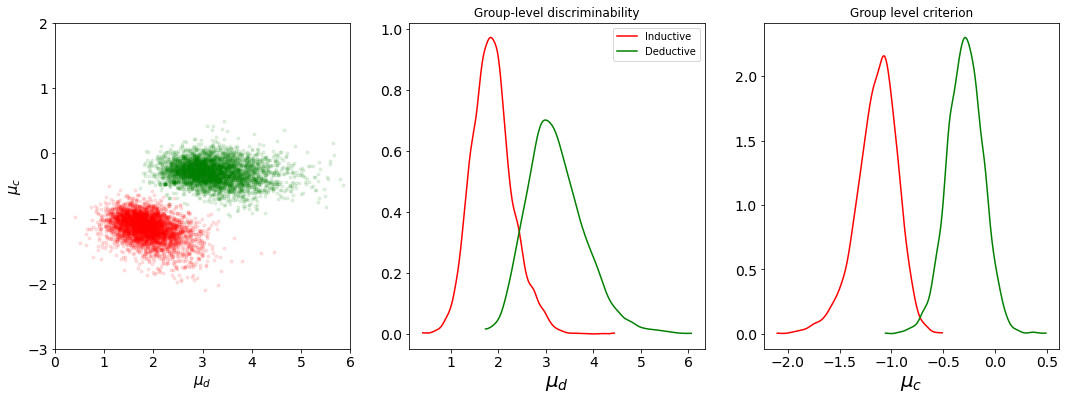

In [55]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
az.plot_pair(data_i, var_names=["mud", "muc"], scatter_kwargs={"alpha": 0.1, "color": "red"}, 
                    figsize = (8,8), ax = ax[0])
az.plot_pair(data_d, var_names=["mud", "muc"], scatter_kwargs={"alpha": 0.1, "color": "green"}, ax=ax[0])
ax[0].set_xlim((0, 6))
ax[0].set_ylim((-3, 2))
ax[0].set_xlabel(r"$\mu_d$")
ax[0].set_ylabel(r"$\mu_c$");
az.plot_dist(trace_i['mud'], ax = ax[1], color = 'red', label = 'Inductive')
az.plot_dist(trace_d['mud'], ax = ax[1], color = 'green', label = 'Deductive')
ax[1].set_xlabel(r"$\mu_d$", fontsize = 20);
ax[1].set_title('Group-level discriminability')
az.plot_dist(trace_i['muc'], ax = ax[2], color = 'red')
az.plot_dist(trace_d['muc'], ax = ax[2], color = 'green')
ax[2].set_xlabel(r"$\mu_c$", fontsize = 20);
ax[2].set_title('Group level criterion');

# Ejercicios

* Basados en la posterior del criterion ¿tiene sentido la conjetura que la deducción humana es simplemente requerir argumentos más fuertes?

* Basados en la posterior de discriminability ¿qué tanto cambia su respuesta al punto anterior? ¿qué tan importante es para la conjetura que la discriminability fuera igual?

# Appendix

In [ ]:
#Hierarchical Drift Diffusion Model (HDDM)
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Hierarchical Drift Diffusion Model (HDDM)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           mu_v -> v;\
           sigma_v -> v;\
           mu_a -> a;\
           sigma_a -> a;\
           mu_z -> z;\
           sigma_z -> z;\
           mu_ndt -> ndt;\
           sigma_ndt -> ndt;\
           v -> x;\
           a -> x;\
           z -> x;\
           ndt -> x;\
           sv -> x;\
           sz -> x;\
           sndt -> x;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$j subject$";\
               v;\
               a;\
               z;\
               ndt;\
               subgraph cluster1 {\
                   margin = 5; labeljust=l; lblstyle="font=\\small";\
                   style = rounded;\
                   label = "$i trial$";\
                   x;\
               }\
           }\
           /* nodes */\
           v [label = "$v_j$", shape = circle];\
           mu_v [label = "$mu_v$", shape = circle];\
           sigma_v [label = "$sig_v$", shape = circle];\
           a [label = "$a_j$", shape = circle];\
           mu_a [label = "$mu_a$", shape = circle];\
           sigma_a [label = "$sig_a$", shape = circle];\
           z [label = "$z_j$", shape = circle];\
           mu_z [label = "$mu_z$", shape = circle];\
           sigma_z [label = "$sig_z$", shape = circle];\
           ndt [label = "$ndt_j$", shape = circle];\
           mu_ndt [label = "$mu_{ndt}$", shape = circle];\
           sigma_ndt [label = "$sig_{ndt}$", shape = circle];\
           sv [label = "$s_v$", shape = circle];\
           sz [label = "$s_z$", shape = circle];\
           sndt [label = "$s_{ndt}$", shape = circle];\
           x [label = "$x_{ji}$", fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_HDDM.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#distributions:
# \mu_v \sim Normal(2,3)
# \sigma_v \sim Half \ Normal(0,2)
# \mu_a \sim Normal(1.5,0.75)
# \sigma_a \sim Half \ Normal(0,0.1)
# \mu_z \sim Normal(0.5,0.5)
# \sigma_z \sim Half \ Normal(0,0.05)
# \mu_{ndt} \sim Normal(0.4,0.2)
# \sigma_{ndt} \sim Half \ Normal(0,1)
# s_v \sim Half \ Normal(0,2)
# s_z \sim Beta(1,3)
# s_{ndt} \sim Half \ Normal(0,0.3)
# a_j \sim \Gamma(\mu_a, \sigma_a^2)
# v_j \sim Normal(\mu_v, \sigma_v^2)
# z_j \sim invlogit(Normal(\mu_z, \sigma_z^2))
# ndt_j \sim Normal(\mu_{ndt}, \sigma_{ndt}^2)
# x_{ji} \sim \frac{\pi}{a_j^2} e^{\left( -v_j a_j z_j - \frac{v_j^2x}{2} \right)} \times \sum_{k=1}^{\infty} k e^{\left(-\frac{k^2\pi^2x}{2a_j^2}\right)} sin(k \pi z_j)


#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}

In [ ]:
#Signal detection theory
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Signal Detection Theory (SDT)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           c -> theta_h;\
           c -> theta_f;\
           d -> theta_h;\
           d -> theta_f;\
           theta_f -> f;\
           theta_h -> h;\
           s -> h;\
           n -> f;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i data sets$";\
               c;\
               d;\
               s;\
               n;\
               h;\
               f;\
               theta_f;\
               theta_h;\
           }\
           /* nodes */\
           c [label = "$c_i$", shape = circle];\
           d [label = "$d_i$", shape = circle];\
           s [label = "$s_i$", fillcolor = gray, style = filled, shape = square];\
           n [label = "$n_i$", fillcolor = gray, style = filled, shape = square];\
           h [label = "$h_i$", fillcolor = gray, style = filled, shape = square];\
           f [label = "$f_i$", fillcolor = gray, style = filled, shape = square];\
           theta_f [label = "$theta_i^f$", shape = circle, peripheries = 2];\
           theta_h [label = "$theta_i^h$", shape = circle, peripheries = 2];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_SDT.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#d_i \sim Normal(0, \frac{1}{2})
#c_i \sim Normal(0,2)
#\theta_i^h = \Phi(\frac{1}{2}d_i - c_i)
#\theta_i^f = \Phi(-\frac{1}{2}d_i - c_i)
#h_i \sim Binomial(\theta_i^h, s_i)
#f_i \sim Binomial(\theta_i^f, n_i)



In [ ]:
# Hierarchical signal detection theory
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Hierarchical Signal Detection Theory (SDT)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           lambda_c -> c;\
           mu_c -> c;\
           lambda_d -> d;\
           mu_d -> d;\
           c -> theta_h;\
           c -> theta_f;\
           d -> theta_h;\
           d -> theta_f;\
           theta_f -> f;\
           theta_h -> h;\
           s -> h;\
           n -> f;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i people$";\
               c;\
               d;\
               s;\
               n;\
               h;\
               f;\
               theta_f;\
               theta_h;\
           }\
           /* nodes */\
           lambda_c [label = "$lam_c$", shape = circle];\
           lambda_d [label = "$lam_d$", shape = circle];\
           mu_c [label = "$mu_c$", shape = circle];\
           mu_d [label = "$mu_d$", shape = circle];\
           c [label = "$c_i$", shape = circle];\
           d [label = "$d_i$", shape = circle];\
           s [label = "$s_i$", fillcolor = gray, style = filled, shape = square];\
           n [label = "$n_i$", fillcolor = gray, style = filled, shape = square];\
           h [label = "$h_i$", fillcolor = gray, style = filled, shape = square];\
           f [label = "$f_i$", fillcolor = gray, style = filled, shape = square];\
           theta_f [label = "$theta_i^f$", shape = circle, peripheries = 2];\
           theta_h [label = "$theta_i^h$", shape = circle, peripheries = 2];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_hSDT.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#\mu_c, \ \mu_d \sim Normal(0,0.001)
#\lambda_c, \ \lambda_d \sim Normal(0.001,0.001)
#d_i \sim Normal(\mu_d, \lambda_d)
#c_i \sim Normal(\mu_c, \lambda_c)
#\theta_i^h = \Phi(\frac{1}{2}d_i - c_i)
#\theta_i^f = \Phi(-\frac{1}{2}d_i - c_i)
#h_i \sim Binomial(\theta_i^h, s_i)
#f_i \sim Binomial(\theta_i^f, n_i)